In [1]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_irl_one_spin"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[ 7.91611093e+00  1.32945262e+01 -1.72798905e+02]
 [ 1.74440622e+01 -2.84222938e+00 -1.17178299e+02]
 [ 1.61217924e+01  1.26230626e+01 -1.68856611e+02]
 [ 2.08974617e+01  3.17871425e+00 -1.41708972e+02]
 [ 2.10863814e+01 -4.10627131e+00 -1.23608057e+02]
 [ 2.16178279e+01  2.87452040e+00 -1.41696488e+02]
 [ 2.06404534e+01 -8.96569617e+00 -1.13195194e+02]
 [ 2.27975667e+01  1.19625619e+00 -1.38664679e+02]
 [ 2.21389340e+01 -6.08645477e+00 -1.21418101e+02]
 [ 1.80585100e+01 -1.43634849e+01 -9.89755940e+01]
 [ 2.11027971e+01 -9.06451460e+00 -1.13899195e+02]
 [ 1.67845295e+01 -1.55298658e+01 -9.44115847e+01]
 [ 6.41417595e+00 -2.11723659e+01 -6.29532543e+01]
 [ 1.62056118e+01 -1.37317433e+01 -9.52779814e+01]
 [ 7.34619092e+00 -1.88773300e+01 -6.59548978e+01]
 [ 1.51735166e+01 -1.11625004e+01 -9.78351739e+01]
 [ 1.19308988e+01 -1.41967496e+01 -8.40986749e+01]
 [-7.08147947e-01 -1.57533182e+01 -4.21042062e+01]
 [-7.83112615e+00 -1.18637309e+01 -1.21357694e+01]
 [ 1.99423264e+00 -7.26220000e+

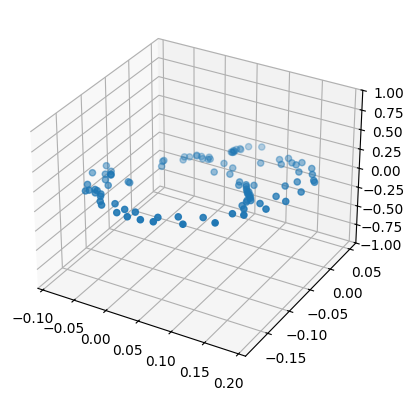

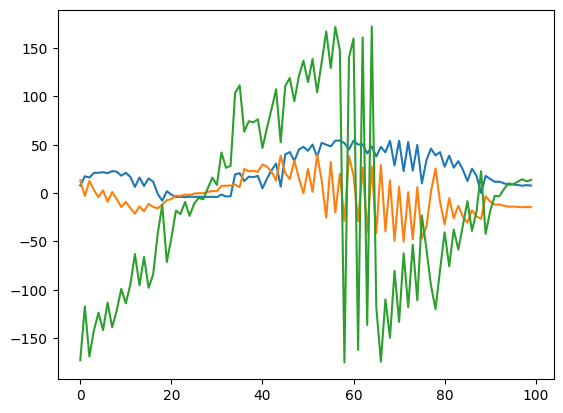

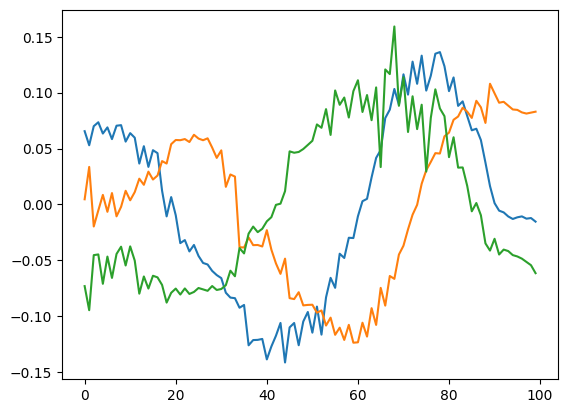

In [2]:

OPENGL = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = np.array(frame["transform_matrix"])
    #tf = np.dot(tf, OPENGL)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))
    
points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#Set z-axis
ax.set_zlim(-1, 1)

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

In [3]:
with open(os.path.join(DATA_PATH, "ground_truth.json"), "r") as f:
    ground_truth = json.load(f)
    
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

ground_truth["frames"] = ground_truth["frames"][0:len(transforms["frames"])]

points = []
euler_angle = []
for frame in ground_truth["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/dust3r/masked_dust3r/data/jackal_irl_one_spin/ground_truth.json'